# Dataset: Stroop Task
In this exercise, we will practice using Pandas, Matplotlib, Seaborn, and Statsmodels. To make the exercises more realistic, we will analyze behavioral data from a classic psychological experiment, the [Stroop task](https://en.wikipedia.org/wiki/Stroop_effect). (These [previously published](https://www.ncbi.nlm.nih.gov/pubmed/25143543) data were made generously available by [Tim Verstynen](https://openfmri.org/dataset/ds000164/).)

In this dataset, participants performed a variant of the Stroop task, in which participants are presented with words written in different color inks. There are three types of trials:
1. Congruent trials (e.g. the word "blue" written in blue ink)
2. Incognruent trials (e.g. the word "red" written in blue ink)
3. Neutral trials: (e.g. the world "car" written in blue ink)

Participants are instructed to name the font color of the word (not the word itself). This is easy for neutral and congruent trials, but more difficult for incongruent trials (e.g. when the word "red" is written in blue font, and the participant must respond "blue"). Classically, we observe an interference effect for incongruent trials such that participants' reaction times slow down and incorrect responses increase for incongruent trials. If you would like to try this for yourself, see [here](https://expfactory.github.io/stroop.html). In total, 28 participants each completed 120 trials of the Stroop task described above with trial types balanced (40 congruent, 40 incongruent, 40 neutral trials). Participansts were given 1s to make their response, recorded via keyboard.

Through a series of exercises, we will perform a basic analysis of the dataset and complete the following steps:
* Aggregate and save a group dataset.
* Rename and recorde variables.
* Filter data to remove bad trials (e.g. missing trials, finger slips)
* Visualize the cleaned dataset. 
* Perform basic statistical analysis of the data.

# Step 1: Assemble the Data
### Assemble all participant data into one DataFrame. 
Be sure to store the subject ID as a new column.

Hint: Be careful of the PDF saved in the stroop data folder.

In [ ]:
import os
from pandas import read_table, concat

## Locate all TSV files.
tsv_files = [f for f in os.listdir('stroop') if f.endswith('tsv')]

## Iteratively load and merge all files.
data = []
for tsv in tsv_files:
    
    ## Get subject ID.
    subj = tsv.replace('.tsv','')
    
    ## Load data.
    tsv = read_table(os.path.join('stroop',tsv), sep='\t')
    
    ## Store subject ID.
    tsv['subj'] = subj
    
    ## Append data to list.
    data.append( tsv )
    
## Concatenate.
data = concat(data)
print('Done.')

# Step 2: Preprocess the Data
## Standardizing the DataFrame
### Sort the data by subject and then reset the index.

In [ ]:
data = data.sort_values('subj')
data = data.reset_index(drop=True)

### Drop unnecessary columns (e.g. duration, onset)

In [ ]:
data = data.drop(['duration','onset'], axis=1)

### Rename column "response_time" to "rt".

In [ ]:
data = data.rename(columns={'response_time':'rt'})

### Set subj and condition as Categorical variables.
Check the memory usage before and after.

In [ ]:
data.info(memory_usage=True)

In [ ]:
from pandas import Categorical

data['subj'] = Categorical(data['subj'])
data['condition'] = Categorical(data['condition'])

data.info(memory_usage=True)

### Find the unique values of the "correct" variable.
What are the values? Are there values indicating missing responses?

In [ ]:
data.correct.unique()

### Recode the values of the "correct" variable: {"Y" = 1, "N" = 0}

In [ ]:
import numpy as np
data['correct'] = np.where(data['correct'] == 'Y', 1, 0)

### Save the standardized group data .
Save as CSV file.

In [ ]:
data.to_csv(os.path.join('stroop', 'group_data.csv'), index=False)

## Filtering the DataFrame.
In our analysis later, we will be measuring the interference effect (i.e. the slowdown in reaction time with competing stimuli). To cleanly measure how much of a slowdown there is, we will want to remove trials with aberrant properties. That is, we want to remove trials whose attributes suggest that the participant's behavior was confounded on that trial. There are three properties we will look for:

1. **Incorrect trials:** incorrect trials are typically faster than correct trials. Can be caused by many factors (lapsed attention, rule-forgetting).
2. **Fast trials:** trials with unrealistically fast reaction times (responding within 100ms). Typically caused by finger slips. 
3. **Slow trials:** trials with uncharacteristically slow reaction times (responding after 5s). Typically caused by lapsed attention.

In the following exercises, you will work to identify and remove these trials.

NOTE: It should be said that cognitive psychologists have much better methods than these for handling aberrant trials. Most procedures do not throw away data (i.e. avoiding garden of forking paths). As a simple exercise, however, we will utilize these simpler techniques as means of instruction.

### Incorrect trials
Though we will ultimately toss away incorrect trials, we do not want to do so blindly. One problematic scenario is if a subject has an accuracy of 50%. This would suggest the subject was responding at random. In this scenario, we would want to toss away all of that subject's data, as they did not understand the task, and not only the trials they responded incorrectly to. In another problematic scenario (accuracy = 65%), we might throw away so many trials such that we have too few trials to reliably estimate an effect of interest. 

As such, we will (arbitrarily) define a required accuracy rate of 75% as the inclusion criterion. All trials corresponding to a subject with an accurate rate lower than 75% will be discarded. 

#### Use groupby to compute ratios of correct trials within participants.
Should any subjects be discarded?

In [ ]:
accuracy_ratio = data.groupby('subj').correct.mean()
accuracy_ratio

In [ ]:
accuracy_ratio[accuracy_ratio < 0.75]

#### Use GroupBy Filter to remove any subjects with less than 75% accuracy.
Identify the remaining subjects to make sure that it worked.

In [ ]:
## Group by subject.
gb = data.groupby('subj')

## Filter on responses.
data = gb.filter(lambda x: x.correct.mean() >= 0.75)

## Identify remaining subjects.
data['subj'].unique()

#### Update the Subject categorical variable.
This step is necessary to ensure proper DataFrame functions after a category is no longer present. To do this, you will need to use the "remove_unused_categories" attribute of the Categorical function. See [here](http://pandas.pydata.org/pandas-docs/stable/categorical.html#removing-categories) for details.

In [ ]:
data['subj'] = Categorical(data['subj']).remove_unused_categories()

#### Remove the remaining incorrect trials.

In [ ]:
data = data[data.correct == 1]

### Fast and Slow Trials
With incorrect trials removed, we move onto removing too-fast and too-slow trials. Before anything else, we should visualize the data. 
Use FacetGrid from Seaborn to visualize all the participants' reaction time data. 

From eyeballing the data, does it appear there are any major outliers?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
%matplotlib inline

## Initialize facetgrid object. Plot.
g = sns.FacetGrid(data, col='subj', col_wrap=5, sharex=True, sharey=False)
g.map(plt.hist, 'rt', bins=10, lw=0.25);

## Cleanup.
plt.tight_layout()
plt.show()

It does not appear as if there are any outliers in the reaction time data worth worrying about (perhaps Subject 8, but even one or two outliers will not hurt). As such, we will not reject any more trials. 

To provide a little more experience, however, in working with Pandas and Scipy, the daring individual can complete the reaction time filtering exercises below. Otherwise, skip to **Step 3**.

In this extra exercise, we will iteratively extract each participant's reaction times, fit a gamma distribution to it, compute the likelihood of observed reaction times given the model fit, and store these values in the DataFrame. Reaction time observations with especially low likelihoods (< 0.3% likelihood) will be removed.

#### Fitting a gamma distribution to each subject's reaction time data.
To do this, you will need to do the following:
* Import gamma from scipy.stats.
* Make a new empty column in the DataFrame.
* In a for loop: 
    * Extract participant's RT data.
    * Fit gamma distribution to RT with location fixed to 0. (Check for the fit attribute of the gamma class.)
    * Using the estimated parameters, compute the CDF of observed reaction times.
    * Store in the empty column for that given participant.

In [ ]:
from scipy.stats import gamma

## Make copy of data.
copy = data.copy()

## Initialize new empty column in DataFrame.
copy['cdf'] = np.nan

## Iterate over subjects.
for subj in data.subj.unique():
    
    ## Extract RTs for that subject.
    rt = copy.loc[copy.subj==subj, 'rt']
    
    ## Fit gamma to RTs.
    alpha, loc, beta = gamma.fit(rt, floc=0)
    
    ## Compute PDF.
    cdf = gamma(alpha, loc, beta).cdf(rt)
    
    ## Store.
    copy.loc[copy.subj==subj,'cdf'] = cdf

#### Remove all trials with CDFs less than 0.3% likelihood (CDF < 3e-3, CDF > 0.997)

In [ ]:
copy = copy[ (copy.cdf > 3e-3) & (copy.cdf < 0.997) ]

# Step 3) Describing and Visualizing the Data
## Summary Tables
### Use GroupBy to compute the mean and standard deviation of the reaction time, across all subjects, for each condition.

In [ ]:
data.groupby('condition').rt.mean()

In [ ]:
data.groupby('condition').rt.std()

## Visualization
### Fancy Barplot
Visualize the average reaction time by condition using Seaborn's barplot command.

In [ ]:
sns.barplot(x='condition', y='rt', data=data);

plt.tight_layout()
sns.despine()

### Francy Histograms, Part 1
Using pivot_table and [Seaborn's Distplot command](https://seaborn.pydata.org/examples/distplot_options.html), compute and visualize the distribution of within-subject average reaction times separated by condition. Be sure to add labels.

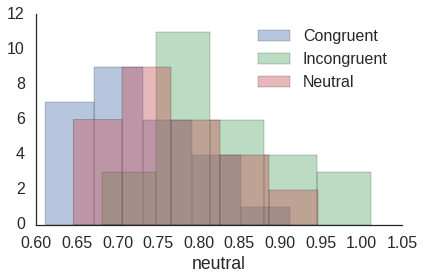

In [58]:
## Compute pivot_table.
pivot_table = data.pivot_table(index='subj', columns='condition', values='rt', aggfunc='mean')

## Plot distributions.
sns.distplot(pivot_table.congruent, kde=False, bins=5, label='Congruent')
sns.distplot(pivot_table.incongruent, kde=False, bins=5, label='Incongruent')
ax = sns.distplot(pivot_table.neutral, kde=False, bins=5, label='Neutral')
ax.legend(loc='best');

## Autoscale.
sns.despine()
plt.tight_layout()

### Fancy Histograms, Part 2
Use the [FacetGrid tutorial](https://seaborn.pydata.org/examples/faceted_histogram.html) to pipe the reaction time data, separated by subject/condition, to the [Distplot command](https://seaborn.pydata.org/examples/distplot_options.html). Try different distplot styles until you find something visually compelling.

Hints: You may want to use *col_wrap* and turn off *sharex/sharey* in FaceGrid.

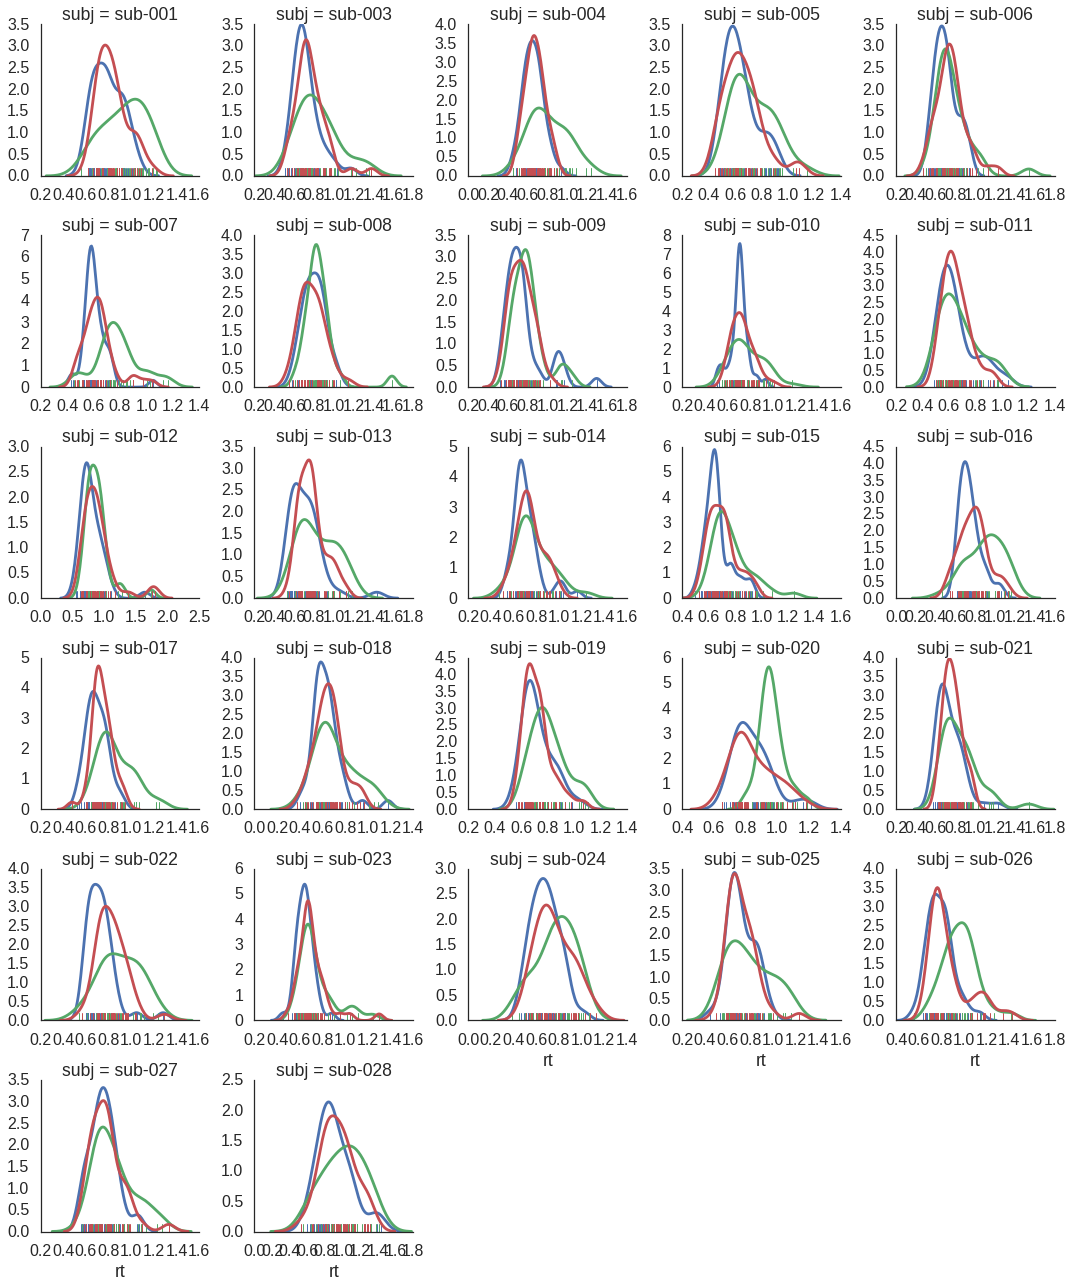

In [42]:
g = sns.FacetGrid(data, col='subj', hue='condition', col_wrap=5, sharex=False, sharey=False)
g.map(sns.distplot, 'rt', hist=False, rug=True)

# Step 4) Compute Statistics

## SciPy Statistics

In [67]:
from scipy.stats import f_oneway, ttest_rel

## Compute pivot-table.
pivot_table = data.pivot_table(index='subj', columns='condition', values='rt', aggfunc='mean')

## Compute oneway ANOVA.
print( f_oneway(pivot_table['congruent'], pivot_table['incongruent'], pivot_table['neutral']) )

## Compute dependent sample t-test.
print( ttest_rel( pivot_table['congruent'], pivot_table['neutral'] ) )
print( ttest_rel( pivot_table['congruent'], pivot_table['incongruent'] ) )

F_onewayResult(statistic=13.68282428799932, pvalue=8.0617023277540117e-06)
Ttest_relResult(statistic=-5.6306261487802454, pvalue=6.4172839316937257e-06)
Ttest_relResult(statistic=-12.931299871131854, pvalue=7.8577643597319965e-13)


## Statsmodels
### Categorical Regression
[See here](http://www.statsmodels.org/stable/example_formulas.html#categorical-variables)

In [69]:
from statsmodels.api import OLS

## Define formula
formula = 'rt ~ C(condition)'

## Fit model.
result = OLS.from_formula(formula, data=data).fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:                OLS                Adj. R-squared:       0.062     
Dependent Variable:   rt                 AIC:                  -2367.5850
Date:                 2017-05-30 17:09   BIC:                  -2349.5719
No. Observations:     2994               Log-Likelihood:       1186.8    
Df Model:             2                  F-statistic:          100.3     
Df Residuals:         2991               Prob (F-statistic):   6.95e-43  
R-squared:            0.063              Scale:                0.026525  
-------------------------------------------------------------------------
                            Coef.  Std.Err.    t     P>|t|  [0.025 0.975]
-------------------------------------------------------------------------
Intercept                   0.7252   0.0049 146.5927 0.0000 0.7155 0.7348
C(condition)[T.incongruent] 0.1050   0.0075  14.0333 0.0000 0.0903 0.1197
C(condition)[T.neutral]     0.0340   0.0070   4.8460 0.0000 0.0203 0.0478
-------------------------------------------------------------------------
Omnibus:               602.611         Durbin-Watson:            1.511   
Prob(Omnibus):         0.000           Jarque-Bera (JB):         1518.752
Skew:                  1.092           Prob(JB):                 0.000   
Kurtosis:              5.721           Condition No.:            4       
=========================================================================

"""

### Dummy Coded Regression

In [76]:
from pandas import get_dummies

## Get dummies.
dummies = get_dummies(data['condition'])

## Merge dummies with data.
data = data.merge(dummies, left_index=True, right_index=True)

## Compute.
formula = 'rt ~ congruent + incongruent'

## Fit.
result = OLS.from_formula(formula, data=data).fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.062     
Dependent Variable: rt               AIC:                -2367.5850
Date:               2017-05-30 17:12 BIC:                -2349.5719
No. Observations:   2994             Log-Likelihood:     1186.8    
Df Model:           2                F-statistic:        100.3     
Df Residuals:       2991             Prob (F-statistic): 6.95e-43  
R-squared:          0.063            Scale:              0.026525  
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       0.7592    0.0050  152.3347  0.0000   0.7494   0.7689
congruent      -0.0340    0.0070   -4.8460  0.0000  -0.0478  -0.0203
incongruent     0.0710    0.0075    9.4541  0.0000   0.0562   0.0857
-------------------------------------------------------------------
Omnibus:             602.611       Durbin-Watson:          1.511   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       1518.752
Skew:                1.092         Prob(JB):               0.000   
Kurtosis:            5.721         Condition No.:          4       
===================================================================

"""

### Mixed Effects Models

In [78]:
from statsmodels.api import MixedLM

## Fit.
result = MixedLM.from_formula(formula, data=data, groups=data.subj).fit()
result.summary()

/home/szoro/Documents/software/anaconda2.7/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: rt       
No. Observations: 2994    Method:             REML     
No. Groups:       27      Scale:              0.0217   
Min. group size:  97      Likelihood:         1430.4475
Max. group size:  117     Converged:          Yes      
Mean group size:  110.9                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.760    0.014 53.028 0.000  0.732  0.789
congruent    -0.035    0.006 -5.508 0.000 -0.047 -0.023
incongruent   0.070    0.007 10.355 0.000  0.057  0.084
groups RE     0.005    0.010                           
=======================================================

"""

In [81]:
re = result.random_effects
for subj, value in sorted(re.iteritems()):
    print('%s = %0.3f' %(subj,value))

sub-001 = 0.079
sub-003 = 0.005
sub-004 = -0.060
sub-005 = -0.089
sub-006 = -0.026
sub-007 = -0.094
sub-008 = 0.041
sub-009 = -0.001
sub-010 = -0.033
sub-011 = -0.098
sub-012 = 0.093
sub-013 = 0.004
sub-014 = -0.023
sub-015 = -0.054
sub-016 = 0.035
sub-017 = -0.008
sub-018 = -0.098
sub-019 = -0.019
sub-020 = 0.108
sub-021 = 0.016
sub-022 = 0.044
sub-023 = -0.068
sub-024 = -0.031
sub-025 = -0.023
sub-026 = 0.100
sub-027 = 0.022
sub-028 = 0.178
